# Python + Pandas is love

L'idéal pour une rapport de données, la validation d'une intuition, vite fait, sur un coin de table, en mode oneshot / quick&dirty ? ~~Excel~~ [Pandas](https://pandas.pydata.org/) !

Nous allons suivre la génération d'un rapport à partir d'un _petit_ dump de données, ce qui va nous permettre de faire une visite guidée des fonctionnalités de pandas. Ce ne sera pas exhaustif, mais devrait vous permettre d'y penser la prochaine fois. 

(Version page web)[https://nbviewer.jupyter.org/github/flo-dhalluin/python-pandas-talk/blob/master/pandas-talk-run.ipynb]

## La base


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

### Serie

Une série, est une séquence de valeurs, de type homogène (toutes du même type : String, entiers, flotants, dates ... ), __ avec un index __

In [2]:
s = pd.Series([5,4,3,2,1,2,3,4,5])
s_datetimes = pd.date_range(start="2017-01-01", periods=86400, freq="2H").to_series()

#display(s.head())
s_datetimes.head()

2017-01-01 00:00:00   2017-01-01 00:00:00
2017-01-01 02:00:00   2017-01-01 02:00:00
2017-01-01 04:00:00   2017-01-01 04:00:00
2017-01-01 06:00:00   2017-01-01 06:00:00
2017-01-01 08:00:00   2017-01-01 08:00:00
Freq: 2H, dtype: datetime64[ns]

## Dataframe

Un Dataframe, c'est un tableau : 
- un ensemble de Series, nommées ( les colonnes)
- qui partagent un index


In [3]:
data = pd.DataFrame({"time": s_datetimes[:120].values,  # get rid of the index
                     "value": np.random.random(120),
                     "category": pd.Categorical(list("abcdef" * 20))})

print(data.info(()))
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 3 columns):
category    120 non-null category
time        120 non-null datetime64[ns]
value       120 non-null float64
dtypes: category(1), datetime64[ns](1), float64(1)
memory usage: 2.3 KB
None


,category,time,value
0,a,2017-01-01 00:00:00,0.656737
1,b,2017-01-01 02:00:00,0.871117
2,c,2017-01-01 04:00:00,0.754182
3,d,2017-01-01 06:00:00,0.364032
4,e,2017-01-01 08:00:00,0.886751


### Import/Export

L'idée étant évidemment d'importer nos données ici, et pas de les générer. Pandas supporte à peu près tout les fichiers formats de données courants :
- csv 
- excel 
- hdf5 
- json/msgpack/parquet

_mais aussi_  on peut créer un dataframe directement depuis une requête SQL, ou même Big Query.

Nous allons ici utiliser la lingua franca de la data ( rappel du contexte : on est sale, on est rapide, on est pas sexys ...) : le csv. 

In [4]:
clients = pd.read_csv("client_files.csv", delimiter=";", index_col=0, parse_dates=[1])
#display(clients.head(4))
events = pd.read_csv("events.csv", delimiter=";", index_col=0, parse_dates=True)
#display(events.info())
print("events is row x cols", events.shape)
print("columns are : ", events.columns)
print("time range:", events.index.min(), events.index.max())
display(events.head(4))

events is row x cols (24850, 4)
columns are :  Index(['client_uuid', 'type', 'doc_type', 'status'], dtype='object')
time range: 2017-01-01 04:11:30 2017-01-21 17:30:19


,client_uuid,type,doc_type,status
timestamp,,,,
2017-01-01 04:11:30,f6cce9e3-7fd1-44ec-b385-a53fcdca326b,DOC,TAX_NOTICE,False
2017-01-01 04:14:27,f6cce9e3-7fd1-44ec-b385-a53fcdca326b,DOC,TAX_NOTICE,True
2017-01-01 04:19:19,f6cce9e3-7fd1-44ec-b385-a53fcdca326b,DOC,RIB,False
2017-01-01 04:22:32,f6cce9e3-7fd1-44ec-b385-a53fcdca326b,DOC,RIB,False


## Let's go

### Les données :

Les clients remplissent des dossiers pour soucrire à des produits, ils doivent envoyer certains justificatifs qui sont
  validés automatiquement (ou pas). events enregistre les différentes soumissions de documents. (client_uuid, correspond à un dossier). comme la validation automatique peut échouer, le client resoumet ces pièces.

### Le problème
Nous voudrions compiler un peu des stats sur le nombre de soumission, par type de dossier ... juste à partir de la table des evenements.


### Requêtes simples

In [5]:
import datetime

cni_events = events[events.doc_type == "CNI"] # keep only CNI type docs
# keep only events occuring on january 10th. 
day_events = events[events.index.date == datetime.date(2017,1,10)]

print("%d events recorded on January 10th" % len(day_events))

# By Index : .ix  - by "position" .iloc 
events.iloc[14:16]

1205 events recorded on January 10th


,client_uuid,type,doc_type,status
timestamp,,,,
2017-01-01 06:03:43,939871ef-54c3-49c0-a127-ea52666281cc,SIGNATURE,NaN,True
2017-01-01 07:09:38,a914159f-873b-479c-9897-d36706cb718c,DOC,PAYSLIP,True


In [6]:
# Pour des requêtes encore plus péchues 

events.query('doc_type=="RIB" & status & index > "20170110"').head()


,client_uuid,type,doc_type,status
timestamp,,,,
2017-01-10 00:14:02,86bfade0-8a3e-4249-a1f0-e7aa430a941c,DOC,RIB,True
2017-01-10 07:51:16,2722498c-fbe9-4140-a7de-e110b63b7b0a,DOC,RIB,True
2017-01-10 08:08:19,3d0b3e4d-44cf-4f3a-8f6c-2d20007e44aa,DOC,RIB,True
2017-01-10 09:00:40,aa378cd3-5fa3-453c-b3e2-c1449f71eb45,DOC,RIB,True
2017-01-10 09:28:54,fafdea11-1f0e-4012-b350-051c88ab06ed,DOC,RIB,True


### GroupBy

> Tableau croisé dynamique, c'est mieux si on en reste là...

Passons dans le vif du sujet, et moulinons un peu nos data.

In [7]:
# comptons les soumissions de documents par type/status. 
(events.groupby(('doc_type','status')) # groupage imbriqué 
       .count())   # fonction d'aggregation 


client_uuid  type
doc_type   status                   
CNI        False          1219  1219
           True           1908  1908
PAYSLIP    False          2436  2436
           True           3717  3717
RIB        False          2491  2491
           True           3774  3774
TAX_NOTICE False          1771  1771
           True           2787  2787

### Split - apply/transform - combine

Insérons ici _une jolie image_ pour illuster le flux de données

In [8]:
# utiliseons groupby pour "numéroter" les soumissions par utilisateurs

# cleanup
events['doc_type'] = events['doc_type'].fillna('NO_DOC')
events["timestamp"] = events.index # --- groupby transform pas très heureux avec les index

# groupons par dossier, puis chaque document
grouped_doc = events.groupby(('client_uuid','doc_type'))

# on transforme une colonne. ( Split - apply - combine)
events['doc_submission_count'] = grouped_doc["timestamp"].transform(np.argsort)
events['time_since_first'] = events.groupby('client_uuid')["timestamp"].transform(lambda ts: ts-ts[0])

events.head()

,client_uuid,type,doc_type,status,timestamp,doc_submission_count,time_since_first
timestamp,,,,,,,
2017-01-01 04:11:30,f6cce9e3-7fd1-44ec-b385-a53fcdca326b,DOC,TAX_NOTICE,False,2017-01-01 04:11:30,0,00:00:00
2017-01-01 04:14:27,f6cce9e3-7fd1-44ec-b385-a53fcdca326b,DOC,TAX_NOTICE,True,2017-01-01 04:14:27,1,00:02:57
2017-01-01 04:19:19,f6cce9e3-7fd1-44ec-b385-a53fcdca326b,DOC,RIB,False,2017-01-01 04:19:19,0,00:07:49
2017-01-01 04:22:32,f6cce9e3-7fd1-44ec-b385-a53fcdca326b,DOC,RIB,False,2017-01-01 04:22:32,1,00:11:02
2017-01-01 04:23:23,f6cce9e3-7fd1-44ec-b385-a53fcdca326b,DOC,RIB,False,2017-01-01 04:23:23,2,00:11:53


In [9]:
# Nb moyen de soumissions de doc avant succés : PAR Type de doc.
(events[events.status==True] # seulement les soumissions ok
     .groupby('doc_type')    # toujours le petit groupby ... 
     .doc_submission_count   # quantième soumission
     .aggregate(['mean', 'max', 'min'])) # aggregation des stats.. 

,mean,max,min
doc_type,,,
CNI,0.454927,2,0
NO_DOC,0.000000,0,0
PAYSLIP,0.462470,2,0
RIB,0.465289,2,0
TAX_NOTICE,0.453534,2,0


### Des graphiques ! 

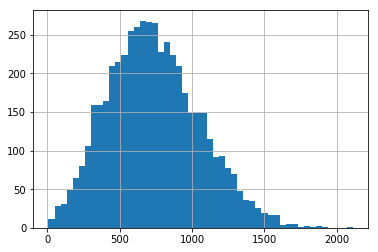

In [10]:
# temps passé par dossier

(events.groupby('client_uuid') # Tu vois ce que je veux dire ? 
     .time_since_first # juste le temps depuis la première action
     .max().map(lambda x: x.total_seconds()) # timedelta -> "float" ( seconds )
     .hist(bins=50)) # KABOOM !


### Encore plus de trucs fun: join et pivot. 

... To be continued

- [sources](https://github.com/flo-dhalluin/python-pandas-talk)
- fait avec [jupyter / notebook](https://jupyter.org/)
- Le saviez vous ? vous pouvez exporter un notebook en slides/reveal.js
